In [165]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import xgboost as xgb
import warnings 
warnings.filterwarnings("ignore")


import os
import random
import tensorflow as tf

# 1. Set Python seed
random.seed(42)

# 2. Set NumPy seed
np.random.seed(42)

# 3. Set TensorFlow seed
tf.random.set_seed(42)

In [31]:
def clean_data(ddf):
  # Drop unnamed index column if present
  ddf = ddf.loc[:, ~ddf.columns.str.contains('^Unnamed')]

  # Convert 'Date' to datetime format
  ddf['Date'] = pd.to_datetime(ddf['Date'])

  # Set 'Date' as the index
  ddf.set_index('Date', inplace=True)

  # Handle missing values if any
  ddf = ddf.dropna()
  return ddf

In [32]:
def feature_engineering(ddf):
  # Daily returns
  ddf['Daily_Return'] = ddf['Close'].pct_change()

  # Moving averages
  ddf['MA5'] = ddf['Close'].rolling(window=5).mean()
  ddf['MA10'] = ddf['Close'].rolling(window=10).mean()

  # Volatility (rolling standard deviation)
  ddf['Volatility'] = ddf['Close'].rolling(window=5).std()

  ddf['Target'] = ddf['Close'].shift(-1)

  # Drop initial NaNs
  ddf.dropna(inplace=True)
  return ddf


In [33]:
# features = ['Open', 'High', 'Low', 'Close', 'Volume', 'Daily_Return', 'MA5', 'MA10', 'Volatility']
features = ['Open', 'High', 'Low', 'Close','MA10', 'Target']

In [80]:
train_df = pd.read_csv(r'D:\Cloudly IO\Tesla-Forcasting-Project\data\preprocessed\Tasla_Stock_Updated_train.csv')
test_df = pd.read_csv(r'D:\Cloudly IO\Tesla-Forcasting-Project\data\preprocessed\Tasla_Stock_Updated_test.csv')

In [81]:
train_df = clean_data(train_df)
test_df = clean_data(test_df)

train_data = feature_engineering(train_df)[features]
test_data = feature_engineering(test_df)[features]

In [82]:
test_data.head()

,Open,High,Low,Close,MA10,Target
Date,,,,,,
2022-04-20,343.333344,344.666656,325.083344,325.733337,336.946671,336.260010
2022-04-21,358.243347,364.073334,332.140015,336.260010,335.714005,335.016663
2022-04-22,338.303345,344.950012,331.333344,335.016663,333.973669,332.673340
2022-04-25,326.323334,336.206665,325.100006,332.673340,333.058005,292.140015
2022-04-26,331.809998,333.333344,291.666656,292.140015,329.741006,293.836670


In [127]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd

# Separate features and target
X_train = train_data.drop(['Target'], axis=1)
y_train = train_data['Target']

X_test = test_data.drop(['Target'], axis=1)
y_test = test_data['Target']

# Scale features
scaler_X = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler_X.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler_X.fit_transform(X_test), columns=X_test.columns, index=X_test.index)

# Scale target
scaler_y = MinMaxScaler()
y_train_scaled = pd.DataFrame(scaler_y.fit_transform(y_train.values.reshape(-1, 1)), columns=['Target'], index=y_train.index)
y_test_scaled = pd.DataFrame(scaler_y.fit_transform(y_test.values.reshape(-1, 1)), columns=['Target'], index=y_test.index)


In [128]:
X_test_scaled

,Open,High,Low,Close,MA10
Date,,,,,
2022-04-20,0.941585,0.923088,0.969363,0.953863,1.000000
2022-04-21,1.000000,1.000000,1.000000,1.000000,0.994445
2022-04-22,0.921878,0.924211,0.996498,0.994551,0.986601
2022-04-25,0.874943,0.889560,0.969435,0.984280,0.982475
2022-04-26,0.896439,0.878172,0.824281,0.806627,0.967526
...,...,...,...,...,...
2024-01-05,0.524441,0.508752,0.577823,0.567102,0.603214
2024-01-08,0.521620,0.513230,0.579560,0.580075,0.596882
2024-01-09,0.529338,0.504155,0.565406,0.556013,0.588959


# Model evaluation

In [40]:
def loss_curve(history):
  # 1. Access loss values
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  # 2. Plot it
  plt.figure(figsize=(10, 6))
  plt.plot(loss, label='Training Loss')
  plt.plot(val_loss, label='Validation Loss')
  plt.title('Neural Network Loss Curve')
  plt.xlabel('Epochs')
  plt.ylabel('MSE Loss')
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.show()

In [41]:
def evaluate_model(model, X_test, y_test):
  # Evaluation Metrics
  y_pred = model.predict(X_test)
  mae = mean_absolute_error(y_test, y_pred)
  rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  r2 = r2_score(y_test, y_pred)

  print(f"MAE: {mae:.2f}")
  print(f"RMSE: {rmse:.2f}")
  print(f"R² Score: {r2:.2f}")

  # Visual Comparison
  plt.figure(figsize=(20,5))
  plt.plot(y_test.values, label='Actual')
  plt.plot(y_pred, label='Predicted')
  plt.title("Actual vs Predicted Tesla Monthly Closing Price")
  plt.legend()
  plt.show()


# XGBoost

In [129]:
X_train_scaled

,Open,High,Low,Close,MA10
Date,,,,,
2015-01-29,0.009743,0.008414,0.009329,0.010245,0.007732
2015-01-30,0.010223,0.008660,0.010422,0.009979,0.007942
2015-02-02,0.010224,0.009399,0.010473,0.011201,0.008262
2015-02-03,0.011758,0.010788,0.011814,0.012436,0.008735
2015-02-04,0.012599,0.010971,0.012744,0.012468,0.009128
...,...,...,...,...,...
2022-03-15,0.619270,0.638828,0.612690,0.643666,0.709780
2022-03-16,0.647240,0.668873,0.651124,0.675585,0.706233
2022-03-17,0.665474,0.696090,0.670859,0.701701,0.709123


In [130]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Train the model
model_xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
model_xgb.fit(X_train_scaled, y_train_scaled)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

MAE: 0.03
RMSE: 0.04
R² Score: 0.95


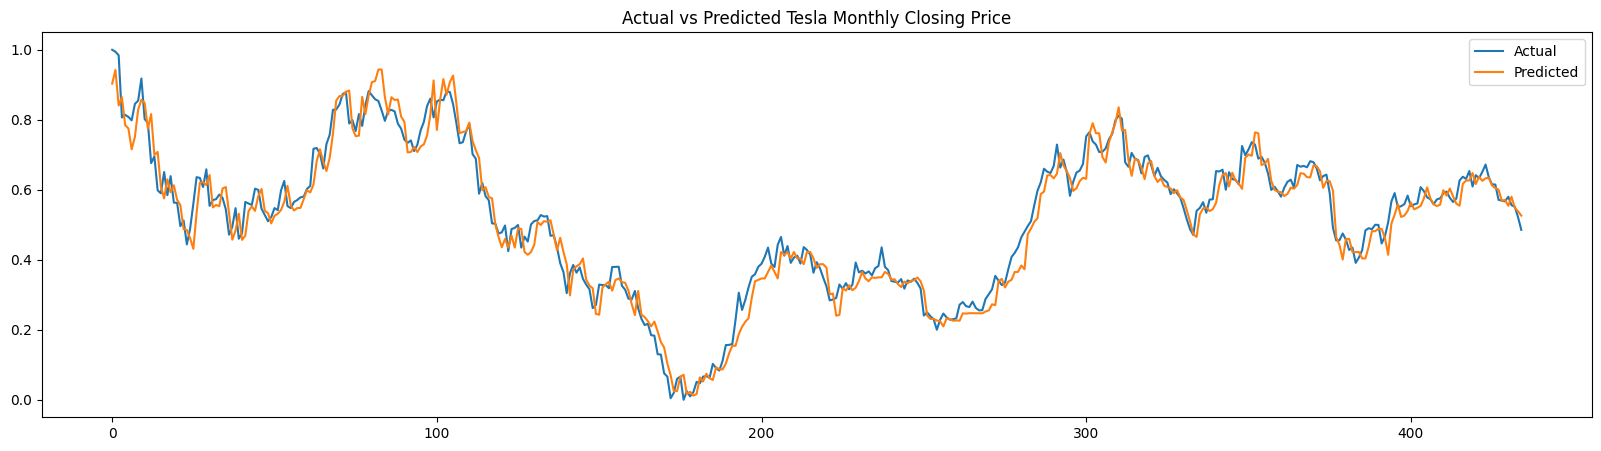

In [131]:
evaluate_model(model_xgb, X_test_scaled, y_test_scaled)

In [ ]:
# joblib.dump(model_xgb, r'D:\Cloudly IO\Tesla-Forcasting-Project\notebook\saved_models\model_xgb.pkl') #Save model

['D:\\Cloudly IO\\Tesla-Forcasting-Project\\notebook\\saved_models\\model_xgb.pkl']

# Linear regression

In [133]:
from sklearn.linear_model import LinearRegression

model_lnr = LinearRegression()
model_lnr.fit(X_train_scaled, y_train_scaled)


LinearRegression()

MAE: 0.03
RMSE: 0.04
R² Score: 0.97


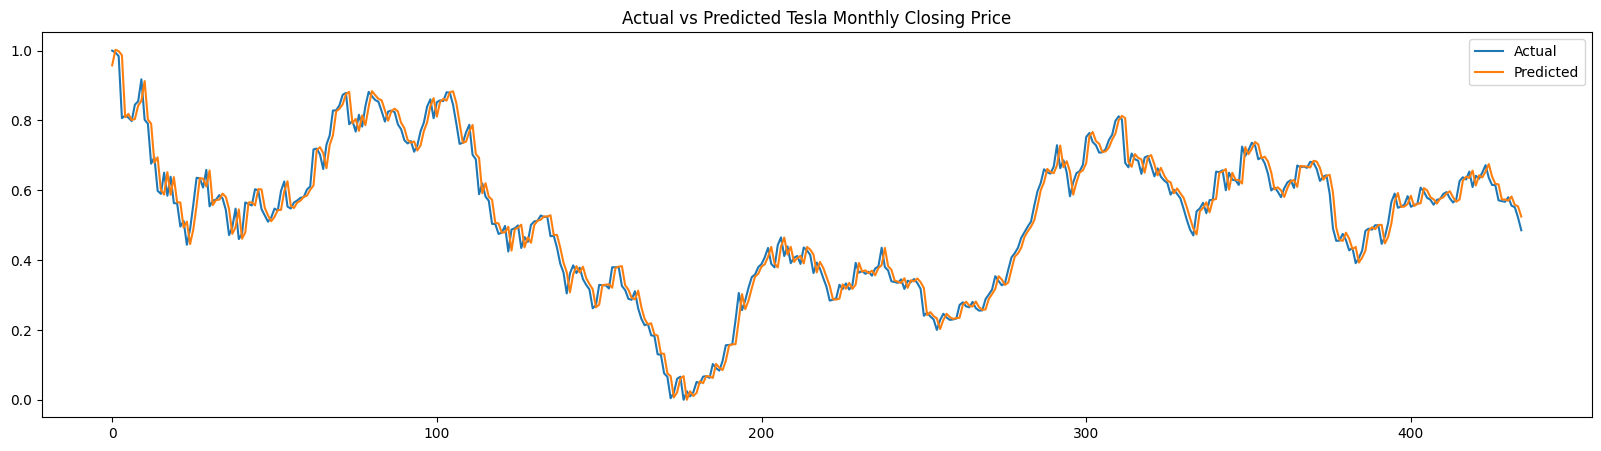

In [134]:
evaluate_model(model_lnr, X_test_scaled, y_test_scaled)

In [ ]:
# joblib.dump(model_lnr, r'D:\Cloudly IO\Tesla-Forcasting-Project\notebook\saved_models\model_lnr.pkl') #Save model

['D:\\Cloudly IO\\Tesla-Forcasting-Project\\notebook\\saved_models\\model_lnr.pkl']

# Neural Nerwork

In [137]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.optimizers import Adam


# 2. Define the model
model_nn = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(1)  # Output: next month's closing price
])

# 3. Compile
model_nn.compile(
    optimizer=Adam(0.001),
    loss='mse',  # regression problem
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# 4. Train with early stopping
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history_nn = model_nn.fit(
    X_train_scaled, y_train_scaled,
    validation_split=0.2,
    epochs=100,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 0.0012 - root_mean_squared_error: 0.0338 - val_loss: 0.0159 - val_root_mean_squared_error: 0.1259
Epoch 2/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.3934e-04 - root_mean_squared_error: 0.0182 - val_loss: 0.0115 - val_root_mean_squared_error: 0.1074
Epoch 3/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 2.3429e-04 - root_mean_squared_error: 0.0151 - val_loss: 0.0032 - val_root_mean_squared_error: 0.0563
Epoch 4/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 3.0071e-04 - root_mean_squared_error: 0.0172 - val_loss: 0.0024 - val_root_mean_squared_error: 0.0488
Epoch 5/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 3.4098e-04 - root_mean_squared_error: 0.0182 - val_loss: 0.0051 - val_root_mean_squared_error: 0.0715
Epoch 6/100
180/180 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step - loss: 2.4653e-04 - root_mean_squared_error: 0.0155 - val_loss: 0.0019 - val_root_mean_squared_error: 0.0434
Epoch 7/100
180/180 ━━━

14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step
MAE: 0.04
RMSE: 0.05
R² Score: 0.95


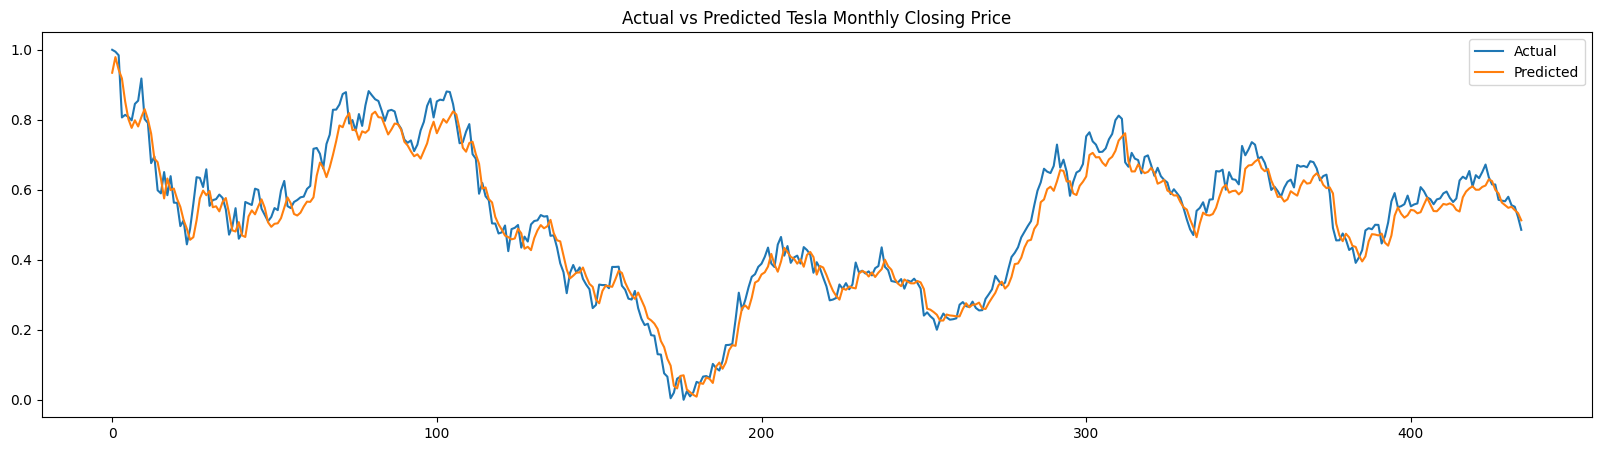

In [138]:
evaluate_model(model_nn, X_test_scaled, y_test_scaled)

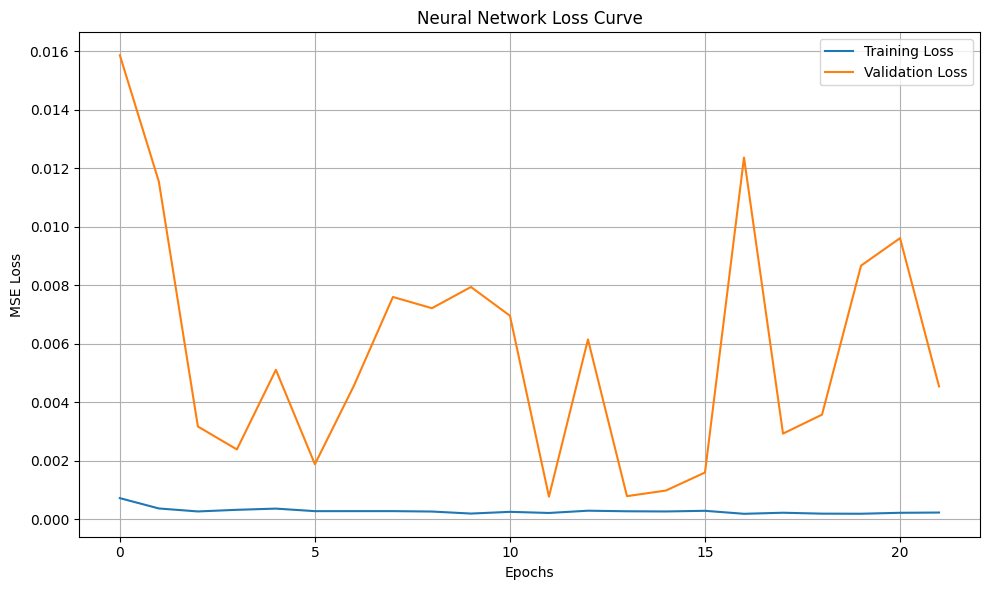

In [139]:
loss_curve(history_nn)

In [ ]:
# joblib.dump(model_nn, r'D:\Cloudly IO\Tesla-Forcasting-Project\notebook\saved_models\model_nn.pkl') #Save model

['D:\\Cloudly IO\\Tesla-Forcasting-Project\\notebook\\saved_models\\model_nn.pkl']

# RNN Based Models

In [141]:
def framing(data: pd.DataFrame, target: pd.Series, window_size: int):
    X, y = [], []

    for i in range(len(data) - window_size):
        X.append(data.iloc[i:(i + window_size)].values)  # use .values for consistency
        y.append(target.iloc[i + window_size])  # safer than target[i + window_size]

    X = np.array(X)
    y = pd.DataFrame(y, columns=['Target'])

    return X, y


In [151]:
train_df_aug = pd.concat([train_df, train_df.tail(501), train_df.tail(300)])[features]
train_df_aug


,Open,High,Low,Close,MA10,Target
Date,,,,,,
2015-01-29,13.404667,13.732000,13.100000,13.680000,13.289667,13.573333
2015-01-30,13.597333,13.831333,13.533333,13.573333,13.367867,14.062667
2015-02-02,13.598000,14.130000,13.553333,14.062667,13.487000,14.557333
2015-02-03,14.214667,14.691333,14.084667,14.557333,13.663200,14.570000
2015-02-04,14.552667,14.765333,14.453333,14.570000,13.809733,14.732667
...,...,...,...,...,...,...
2022-03-15,258.423340,268.523346,252.190002,267.296661,274.910995,280.076660
2022-03-16,269.666656,280.666656,267.420013,280.076660,273.588995,290.533325
2022-03-17,276.996674,291.666656,275.239990,290.533325,274.665994,301.796661


In [153]:
#Features and Target Seperation of Train Data
X_train_RNN = train_df_aug.drop(['Target'], axis=1)
y_train_RNN = train_df_aug['Target']

X_test_RNN = test_df[features].drop(['Target'], axis=1)
y_test_RNN = test_df['Target']

##Testing purpose

# Scale features
scaler_X = MinMaxScaler()
X_train_RNN = pd.DataFrame(scaler_X.fit_transform(X_train_RNN), columns=X_train_RNN.columns, index=X_train_RNN.index)
X_test_RNN = pd.DataFrame(scaler_X.fit_transform(X_test_RNN), columns=X_test_RNN.columns, index=X_test_RNN.index)

# Scale target
scaler_y = MinMaxScaler()
y_train_RNN = pd.DataFrame(scaler_y.fit_transform(y_train_RNN.values.reshape(-1, 1)), columns=['Target'], index=y_train_RNN.index)
y_test_RNN = pd.DataFrame(scaler_y.fit_transform(y_test_RNN.values.reshape(-1, 1)), columns=['Target'], index=y_test_RNN.index)



In [154]:
X_test_RNN

,Open,High,Low,Close,MA10
Date,,,,,
2022-04-20,0.941585,0.923088,0.969363,0.953863,1.000000
2022-04-21,1.000000,1.000000,1.000000,1.000000,0.994445
2022-04-22,0.921878,0.924211,0.996498,0.994551,0.986601
2022-04-25,0.874943,0.889560,0.969435,0.984280,0.982475
2022-04-26,0.896439,0.878172,0.824281,0.806627,0.967526
...,...,...,...,...,...
2024-01-05,0.524441,0.508752,0.577823,0.567102,0.603214
2024-01-08,0.521620,0.513230,0.579560,0.580075,0.596882
2024-01-09,0.529338,0.504155,0.565406,0.556013,0.588959


In [155]:
X_train_RNN , y_train_RNN = framing(X_train_RNN, y_train_RNN, 5)
X_test_RNN , y_test_RNN = framing(X_test_RNN, y_test_RNN, 5)

In [156]:
X_train_RNN[0]

array([[0.00974339, 0.00841405, 0.00932882, 0.01024496, 0.00773245],
       [0.01022268, 0.00865982, 0.01042236, 0.00997855, 0.0079423 ],
       [0.01022434, 0.00939879, 0.01047284, 0.01120069, 0.00826199],
       [0.01175841, 0.01078766, 0.0118137 , 0.01243614, 0.00873481],
       [0.01259924, 0.01097076, 0.01274405, 0.01246778, 0.00912803]])

## LSTM

In [160]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.optimizers import Adam


# 2. Define the LSTM model
model_lstm = Sequential([
    LSTM(50, activation='tanh', return_sequences=True, input_shape=(X_train_RNN.shape[1], X_train_RNN.shape[2])),
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(X_train_RNN.shape[1], X_train_RNN.shape[2])),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(32, activation='relu'),
    Dropout(0.1),
    Dense(16, activation='relu'),
    Dropout(0.1),
    Dense(1, activation= 'linear')
])

# 3. Compile
model_lstm.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# 4. Train
early_stop = EarlyStopping(patience=20, restore_best_weights=True)

history_lstm = model_lstm.fit(
    X_train_RNN, y_train_RNN,
    validation_split=0.2,
    epochs=64,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/64
260/260 ━━━━━━━━━━━━━━━━━━━━ 26s 39ms/step - loss: 0.0164 - root_mean_squared_error: 0.1227 - val_loss: 0.0060 - val_root_mean_squared_error: 0.0775
Epoch 2/64
260/260 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 0.0047 - root_mean_squared_error: 0.0683 - val_loss: 0.0037 - val_root_mean_squared_error: 0.0608
Epoch 3/64
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - loss: 0.0043 - root_mean_squared_error: 0.0654 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0504
Epoch 4/64
260/260 ━━━━━━━━━━━━━━━━━━━━ 14s 53ms/step - loss: 0.0037 - root_mean_squared_error: 0.0607 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0500
Epoch 5/64
260/260 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - loss: 0.0034 - root_mean_squared_error: 0.0582 - val_loss: 0.0029 - val_root_mean_squared_error: 0.0534
Epoch 6/64
260/260 ━━━━━━━━━━━━━━━━━━━━ 12s 45ms/step - loss: 0.0027 - root_mean_squared_error: 0.0519 - val_loss: 0.0025 - val_root_mean_squared_error: 0.0501
Epoch 7/64
260/260 ━━━━━━━━━━━━━━━━━━━━ 2

14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step
MAE: 0.04
RMSE: 0.06
R² Score: 0.92


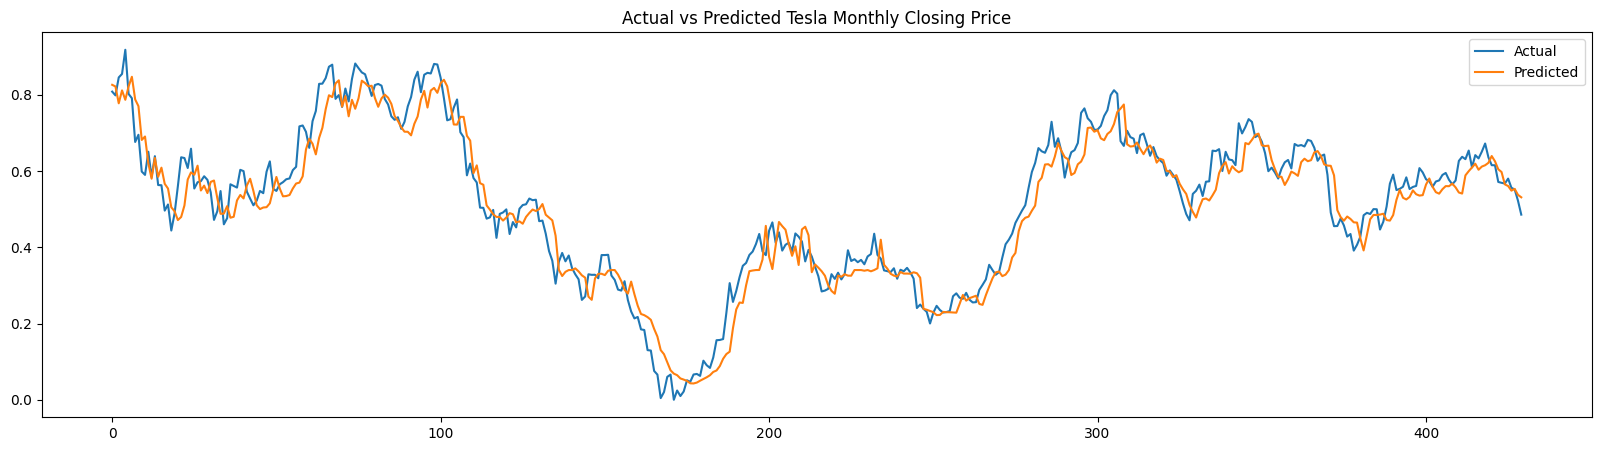

In [161]:
# evaluate_model(model_lstm, X_train_RNN, y_train_RNN)
evaluate_model(model_lstm, X_test_RNN, y_test_RNN)

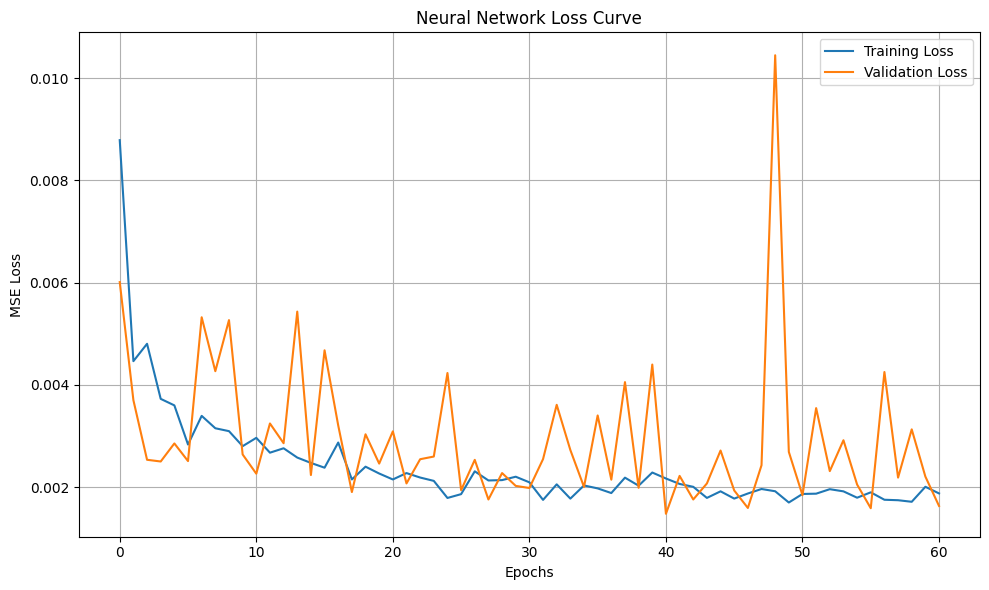

In [162]:
loss_curve(history_lstm)

In [ ]:
import joblib
# joblib.dump(model_lstm, r'D:\Cloudly IO\Tesla-Forcasting-Project\notebook\saved_models\model_lstm.pkl') #Save model

['D:\\Cloudly IO\\Tesla-Forcasting-Project\\notebook\\saved_models\\model_lstm.pkl']

## GRU

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, GRU
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay


# Define the GRU model
model_gru = Sequential([
    GRU(128, return_sequences=True, input_shape=(X_train_RNN.shape[1], X_train_RNN.shape[2])),
    Dropout(0.3),
    GRU(64, return_sequences=True),
    Dropout(0.2),
    GRU(64, return_sequences=False),
    Dense(64, activation='relu'),
    Dropout(0.2),
    # Dense(32, activation='relu'),
    # Dropout(0.1),
    Dense(1)
])

# 3. Compile

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=1000,
    decay_rate=0.9
)

optimizer = Adam(learning_rate=lr_schedule)

model_gru.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# 4. Train
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

history_gru = model_gru.fit(
    X_train_RNN, y_train_RNN,
    validation_split=0.2,
    epochs=64,
    batch_size=8,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/64
261/261 ━━━━━━━━━━━━━━━━━━━━ 32s 35ms/step - loss: 0.0936 - root_mean_squared_error: 0.2879 - val_loss: 0.0468 - val_root_mean_squared_error: 0.2164
Epoch 2/64
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.0315 - root_mean_squared_error: 0.1767 - val_loss: 0.0256 - val_root_mean_squared_error: 0.1600
Epoch 3/64
261/261 ━━━━━━━━━━━━━━━━━━━━ 14s 50ms/step - loss: 0.0300 - root_mean_squared_error: 0.1722 - val_loss: 0.0429 - val_root_mean_squared_error: 0.2071
Epoch 4/64
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 37ms/step - loss: 0.0259 - root_mean_squared_error: 0.1600 - val_loss: 0.0247 - val_root_mean_squared_error: 0.1571
Epoch 5/64
261/261 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0284 - root_mean_squared_error: 0.1674 - val_loss: 0.0278 - val_root_mean_squared_error: 0.1668
Epoch 6/64
261/261 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - loss: 0.0218 - root_mean_squared_error: 0.1466 - val_loss: 0.0207 - val_root_mean_squared_error: 0.1440
Epoch 7/64
261/261 ━━━━━━━━━━━━━━━━━━━━ 23

14/14 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step
MAE: 0.08
RMSE: 0.10
R² Score: 0.93


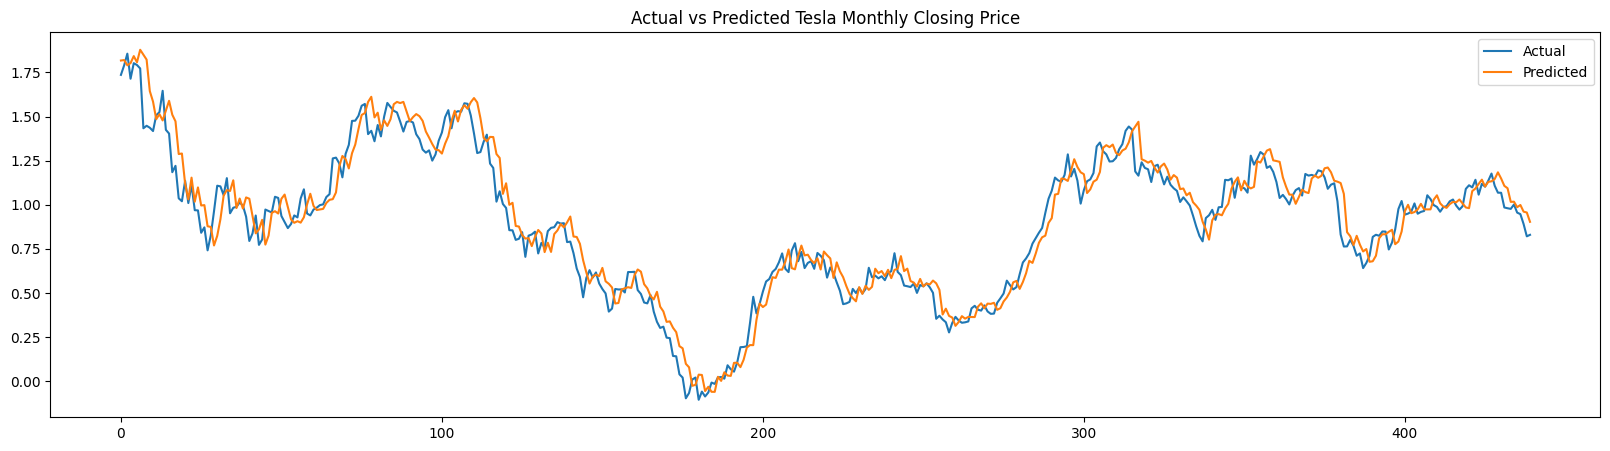

In [25]:
# evaluate_model(model_gru, X_train_RNN, y_train_RNN)
evaluate_model(model_gru, X_test_RNN, y_test_RNN)

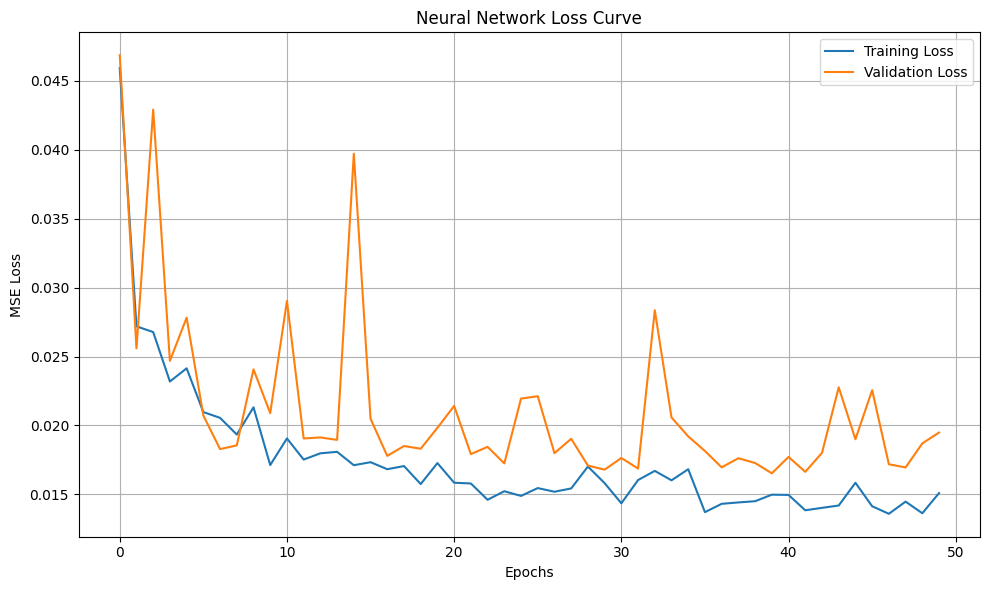

In [26]:
loss_curve(history_gru)

In [ ]:
# joblib.dump(model_gru, r'D:\Cloudly IO\Tesla-Forcasting-Project\notebook\saved_models\model_gru.pkl') #Save model

['D:\\Cloudly IO\\Tesla-Forcasting-Project\\notebook\\saved_models\\model_gru.pkl']